### Imports

In [2]:
import copy
import glob
import importlib
import math
import operator
import os
import shutil
import time
from math import ceil, floor
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage.morphology
import skimage.measure

import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import voi_methods as vm
import seg_methods as sm

%matplotlib inline
np.set_printoptions(3)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()
base_dir = "D:\\Etiology\\Imaging"

for sheet in C.sheetnames:
    src_data_df = pd.read_excel(C.xls_name, sheet)
    a = []
    for _, row in src_data_df.iterrows():
        a.append(row["z2"] - row["z1"])
    print(np.median(a) / C.lesion_ratio)

A=['3437803','3415958','4925916','3416369','4051676','3384631','1822692','2119429','5510129','5533845','5579303','5622049','5878296','5883280','5825081','2626120','5833349']

for root, _, _ in os.walk("E:"):
    for a in A:
        if basename(root).startswith(a):
            print(root)
            A.remove(a)

# Generate data

### Load DCM

In [33]:
def sort_by_series_num(arr):
    return sorted(arr, key=lambda x: int(x[x.rfind("_")+1:]))

def semiauto_rename_phases(lesion_dir):
    for accnum in glob.glob(join(lesion_dir, "*")):
        fnames = [join(accnum, x) for x in C.phases]
        if np.all([exists(fnames[i]) for i in range(len(fnames))]):
            continue

        #PRE = [x for x in os.listdir(accnum) if "pre" in x] #("vibe" in x or "axial abd" in x) and 
        #if len(PRE) > 1:
        #    PRE = [x for x in PRE if "reg" in x]

        DCE = [x for x in os.listdir(accnum) if ("vibe" in x or "dynamic" in x) and "post" in x and "sub" not in x]
        if len(DCE) > 0:
            DCE = sort_by_series_num([x for x in DCE if "min" not in x])
        else:
            DCE = [x for x in os.listdir(accnum) if "art" in x and "reg" in x] + \
                    [x for x in os.listdir(accnum) if ("port" in x or "pv" in x) and "reg" in x] + \
                    [x for x in os.listdir(accnum) if "equ" in x and "reg" in x]
        if len(DCE) == 0:
            DCE = [x for x in os.listdir(accnum) if "ART" in x] + \
                    [x for x in os.listdir(accnum) if "PV" in x] + \
                    [x for x in os.listdir(accnum) if "DL" in x]
        if len(DCE) < 3: #len(PRE) == 0 or 
            continue

        print(accnum, DCE[0], DCE[1], DCE[2], sep="\n") #sort_by_series_num(PRE)[-1], 
        correct = input()
        if correct == "0":
            for i in range(len(C.phases)):
                os.rename(join(accnum, DCE[i]), join(accnum, C.phases[i]))
        elif correct == "q":
            return
        else:
            continue

In [ ]:
for cat in C.sheetnames:
    print(len(dfs[cat]))
    dfs[cat] = dfs[cat][(dfs[cat]['dx']>0) & (dfs[cat]['dy']>0) & (dfs[cat]['dz']>0)]
    print(len(dfs[cat]))

In [121]:
accnum = "5276207"
load_dir = join(C.dcm_dirs[0], accnum)

In [ ]:
hf.fill_dcm_missing_slices(join(load_dir, C.phases[1]))

In [123]:
importlib.reload(hf)
art, D = hf.dcm_load(join(load_dir, C.phases[0]))#, flip_z=True)
ven, E = hf.dcm_load(join(load_dir, C.phases[1]))
eq,_ = hf.dcm_load(join(load_dir, C.phases[2]))#, flip_z=True)

art.shape, ven.shape, eq.shape

IndexError: list index out of range

In [100]:
hf.save_nii(art, join(load_dir, "nii_dir", "20s.nii.gz"), D)
hf.save_nii(ven, join(load_dir, "nii_dir", "70s.nii.gz"), D)
hf.save_nii(eq, join(load_dir, "nii_dir", "3min.nii.gz"), D)

In [117]:
art,_ = hf.nii_load(join(load_dir, "nii_dir", "20s.nii.gz"))
ven,_ = hf.nii_load(join(load_dir, "nii_dir", "70s.nii.gz"))
eq,_ = hf.nii_load(join(load_dir, "nii_dir", "3min.nii.gz"))

In [119]:
accnums=["4750142"]
#load_dir = join(C.dcm_dirs[0], accnums[0])
#masks.off2ids(join(load_dir, 'Segs', 'tumor_20s.off'), R=[2,2,3])
importlib.reload(drm)
drm.dcm2npy(accnums=accnums, overwrite=True)
drm.tricolorize(accnums)
vm.extract_seg_vois(accnums)
vm.save_seg_set(accnums, num_cores=1)

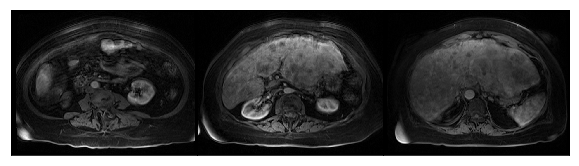

In [115]:
vis.draw_slices(art)

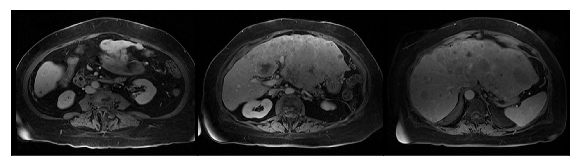

In [116]:
vis.draw_slices(ven)

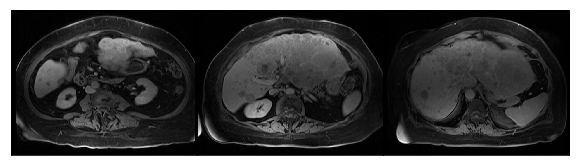

In [118]:
vis.draw_slices(eq)

In [ ]:
hf.split_dcm(join(load_dir, C.phases[2]))
shutil.rmtree(join(load_dir, C.phases[1]))
shutil.rmtree(join(load_dir, C.phases[2]))
shutil.rmtree(join(load_dir, C.phases[2])+"_bin0")
os.rename(join(load_dir, C.phases[2])+"_bin1", join(load_dir, C.phases[1]))
os.rename(join(load_dir, C.phases[2])+"_bin2", join(load_dir, C.phases[2]))

In [41]:
print(load_dir)

D:\Etiology\Imaging\4447056


In [851]:
art = tr.rescale_img(art, E, D)
eq = tr.rescale_img(eq, E, D)

importlib.reload(hf)
hf.create_dicom(art, join(load_dir, C.phases[0]), E, True)
hf.create_dicom(eq, join(load_dir, C.phases[2]), E, True)

In [ ]:
cls = "nonviral"
voi_df_art = drm.get_voi_dfs()[0]
accnums = voi_df_art.loc[voi_df_art["cls"] == cls, "accnum"].values[:5]
vm.load_accnum(cls, accnums)

### Load npys

In [7]:
importlib.reload(drm)
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
drm.build_coords_df(accnum_xls_path)

HBV
....................................HCV
........................................................................................................................................Nonviral
.....................................................................................

In [ ]:
input_df = pd.read_excel(accnum_xls_path,
             sheetname="Prelim Analysis Patients", index_col=0, parse_cols="A,J")
accnum_dict = {category: list(input_df[input_df["Category"] == category].index.astype(str)) for category in C.sheetnames}
accnum_dict["HBV"]

In [ ]:
drm.load_vois()

In [ ]:
vm.extract_vois()

In [24]:
os.remove(C.art_voi_path)
os.remove(C.ven_voi_path)
os.remove(C.eq_voi_path)

In [133]:
accnum = "2435642"
load_dir = join(C.dcm_dirs[0], accnum)

In [37]:
I = np.load(join(C.full_img_dir, accnum+"_tumorseg.npy"))

In [ ]:
t = time.time()
masks.off2ids(join(load_dir, 'Segs', 'liver.off'), R=[2,2,3], num_foci=1)
print(time.time() - t)

In [10]:
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
input_df = pd.read_excel(accnum_xls_path,
             sheetname="Prelim Analysis Patients", index_col=0, parse_cols="A,J")

accnum_dict = {category: list(input_df[input_df["Category"] == category].index.astype(str)) for category in C.sheetnames}
accnum_dict['Nonviral'] = accnum_dict["Nonviral"][37:]
accnum_dict.pop('HBV');
accnum_dict.pop('HCV');

In [21]:
accnum_dict['Nonviral'] = accnum_dict["Nonviral"][1:]

In [ ]:
importlib.reload(drm)
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
drm.off2ids_batch(accnum_dict=accnum_dict)

In [ ]:
drm.load_vois(overwrite=True)

In [25]:
os.remove(C.small_voi_path)

In [ ]:
importlib.reload(vm)
vm.extract_vois(overwrite=True)

In [30]:
vm.save_unaugmented_set(overwrite=True)

In [ ]:
voi_df_art.drop("670064_0", inplace=True)
voi_df_art.to_csv(C.art_voi_path)

In [ ]:
voi_df_art = drm.get_voi_dfs()[0]
voi_df_art.loc["1800356_0"]

In [140]:
off_path=join(base_dir, "1800356", "Segs", "tumor_20s.off")

In [141]:
importlib.reload(masks)
masks.off2ids(off_path)

### Vois

In [ ]:
importlib.reload(hf)
C = config.Config()
voi_df_art = drm.get_voi_dfs()[0]
voi_df_art.accnum = voi_df_art.accnum.astype(str)
img_fns = [fn for fn in glob.glob(join(C.full_img_dir, "*.npy")) if not fn.endswith("seg.npy")]

for img_fn in img_fns:
    if not exists(img_fn[:-4]+"_tumorseg.npy") or not exists(img_fn[:-4]+"_liverseg.npy"):
        continue
    img = np.load(img_fn)
    hf.save_tricolor_dcm(join(r"D:\Etiology\imgs\tricolor", basename(img_fn)[:-4]), imgs=img)

In [134]:
hf.create_dicom(G, "D:\\temp", R, overwrite=True)

In [16]:
I=np.load(join(C.full_img_dir, "1800356_liverseg.npy"))

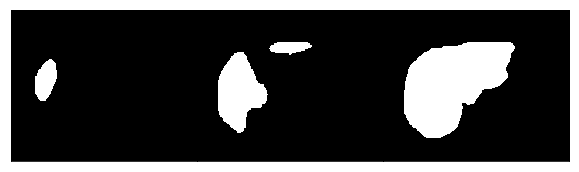

In [17]:
vis.draw_slices(I)

In [11]:
importlib.reload(vm)
vm.save_vois_as_imgs(save_dir="D:\\Etiology\\screenshots", separate_by_cls=False)

In [34]:
I=np.load(join(C.full_img_dir, "hbv", "790003_0.npy"))
I.shape

(256, 192, 44, 3)

In [41]:
voi_df_art = drm.get_voi_dfs()[0]
voi_df_art.drop(voi_df_art.index[~voi_df_art.index.str.endswith("_0")], inplace=True)
voi_df_art.to_csv(C.art_voi_path)

In [42]:
voi_df_art = drm.get_voi_dfs()[0]
voi_df_art = voi_df_art[(voi_df_art["real_dx"] > 0) & (voi_df_art["real_dy"] > 0) & (voi_df_art["real_dz"] > 0)]
voi_df_art = voi_df_art[(voi_df_art["real_dx"] < 50) & (voi_df_art["real_dy"] < 50) & (voi_df_art["real_dz"] < 50)]
voi_df_art = voi_df_art[(voi_df_art["x1"] > 0) & (voi_df_art["y1"] > 0) & (voi_df_art["z1"] > 0)]
voi_df_art.to_csv(C.art_voi_path)

In [313]:
cls = "HBV"
I_path = glob.glob(join(C.full_img_dir, cls, "*"))[0]
cI_path = glob.glob(join(C.crops_dir, cls, "*"))[0]
lesion_id = basename(fn)[:-4]
accnum = lesion_id[:lesion_id.find('_')]
load_dir = join(C.dcm_dirs[0], accnum)

In [301]:
off_path = join(load_dir, "Segs", "tumor_20s.off")
masks.off2ids(off_path)

importlib.reload(masks)
M_path = glob.glob(join(load_dir, "Segs", "*_0.ids"))[0]

In [ ]:
voi_df_art = drm.get_voi_dfs()[0]
voi_df_art[(voi_df_art["accnum"] == accnum)]

In [294]:
importlib.reload(masks)
M = masks.crop_img_to_mask_vicinity(join(load_dir, 'T1_20s'), M_path, padding=.5, add_mask_cont=True)

In [346]:
small_voi_df = pd.read_csv(C.small_voi_path, index_col=0)
small_voi_df["accnum"] = small_voi_df["accnum"].astype(str)

In [237]:
masks.create_dcm_with_mask(join(load_dir, 'T1_20s'), M_path, "D:\\Test", overwrite=True)

In [ ]:
importlib.reload(vm)
[vm.reset_accnum(x) for x in ["12807018"]];

vm.reload_accnum('hcc', ['E100793044', '13216353', 'E101892543', '13278054', 'E101779513', 'E101686218'], augment=True, overwrite=True)

In [100]:
small_voi_df = pd.read_csv(C.small_voi_path)
small_voi_df[small_voi_df["acc_num"] == "E101779513"]

In [ ]:
vm.save_augmented_set(cls="nonviral", overwrite=False)

In [919]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [ ]:
importlib.reload(vm)
vm.xref_dirs_with_excel()

### Paula

In [3]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

In [5]:
importlib.reload(vm)
vm.save_vois_as_imgs(save_dir="D:\\Paula-project\\screenshots\\small", separate_by_cls=True)
vm.save_imgs_with_bbox(save_dir="D:\\Paula-project\\screenshots\\large", separate_by_cls=True)

In [ ]:
voi_df_art[voi_df_art['id'].str.contains('2424_2')]
#voi_df_art[voi_df_art.index.str.contains('9185_0')]

In [109]:
d=[]
for i in range(6):
    df = pd.read_excel('Z:\\Prototype1e.xlsx', sheetname=C.sheetnames[i])
    d.append(df[df['Run'] <= 2]['Diameter'].values)
d = np.concatenate(d)
np.std(d)

In [ ]:
A = glob.glob(r"D:\Etiology\OrigData\*")
A = [basename(x) for x in A]
A = A[5:-3]
A = [x[:x.find(' ')] if ' ' in x else x for x in A]
A = [x[:x.find('_')] if '_' in x else x for x in A]
df = pd.DataFrame(A)
df.to_excel("D:\\temp.xlsx")

# Plotting

In [141]:
src_data_df = drm.get_coords_df("hbv")

In [188]:
importlib.reload(vm)
vm.save_segs_as_imgs(save_dir=r"D:\Etiology\imgs\samples", normalize=[-1,1])

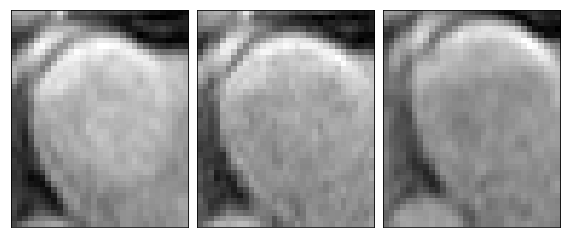

In [139]:
I = np.load(r"D:\Etiology\imgs\rough_crops\2435642_1.npy")
vis.draw_slices(I)

In [35]:
accnum = "4252236"
load_dir = join(C.dcm_dirs[0], accnum)

art,D = hf.load_img(join(load_dir, "nii_dir", "20s.nii.gz"))#hf.dcm_load(join(load_dir, C.phases[0]))
ven,_ = hf.load_img(join(load_dir, "nii_dir", "70s.nii.gz")) #hf.dcm_load(join(load_dir, C.phases[1]))[0]
eq,_ = hf.load_img(join(load_dir, "nii_dir", "3min.nii.gz")) #hf.dcm_load(join(load_dir, C.phases[2]))[0]

In [3]:
for fn in glob.glob(r"D:\Etiology\Imaging\*\nii_dir"):
    try:
        load_dir = dirname(fn)
        shutil.rmtree(join(load_dir, "nii_dir"))
        time.sleep(0.01)
        os.makedirs(join(load_dir, "nii_dir"))
    except:
        continue

In [70]:
[basename(dirname(fn)) for fn in glob.glob(r"D:\Etiology\Imaging\*\T1_20s")].index(accnum)

512

In [26]:
os.makedirs(join(load_dir, "nii_dir"))

In [ ]:
for fn in glob.glob(r"D:\Etiology\Imaging\*\T1_20s")[512:]:
    try:
        load_dir = dirname(fn)
        accnum = basename(load_dir)
        art,D = hf.load_img(join(load_dir, "T1_20s"))
        ven,_ = hf.load_img(join(load_dir, "T1_70s"))
        eq,_ = hf.load_img(join(load_dir, "T1_3min"))
    except:
        continue
        
    try:
        if exists(join(load_dir, "nii_dir")):
            shutil.rmtree(join(load_dir, "nii_dir"))
            time.sleep(0.01)
        os.makedirs(join(load_dir, "nii_dir"))
        hf.save_nii(art, join(load_dir, "nii_dir", "20s.nii.gz"), D)
        hf.save_nii(ven, join(load_dir, "nii_dir", "70s.nii.gz"), D)
        hf.save_nii(eq, join(load_dir, "nii_dir", "3min.nii.gz"), D)
        
        art, ven, eq, slice_shift = reg.crop_reg(art, ven, eq)
        img = np.stack((art, ven, eq), -1)
        
        downsample = 1
        if np.product(art.shape) > C.max_size:
            downsample = 2
            img = tr.scale3d(img, [1/downsample, 1/downsample, 1])
            D = [D[0]*downsample, D[1]*downsample, D[2]]

        np.save(join(C.full_img_dir, accnum+".npy"), img)
        sm.save_segs([accnum], downsample, slice_shift, art.shape[-1])
    except:
        raise ValueError(accnum)

In [ ]:
importlib.reload(drm)
drm.dcm2npy(overwrite=True)

In [33]:
importlib.reload(drm)
drm.dcm2npy(accnums=["1146507"], overwrite=True)

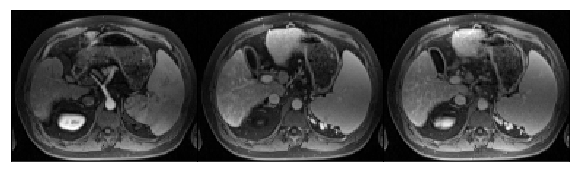

In [177]:
accnum = "1146507"
I = np.load(join(C.full_img_dir, accnum+".npy"))
vis.draw_slices(I)

In [ ]:
importlib.reload(reg)
art, ven, eq, slice_shift = reg.crop_reg(art, ven, eq)

In [24]:
img = np.stack((art, ven, eq), -1)

In [25]:
hf.save_tricolor_dcm("D:\\temp", imgs=img)

In [3]:
importlib.reload(drm)
drm.tricolorize()

In [ ]:
drm.load_vois(overwrite=True)

(256, 208, 80, 3)


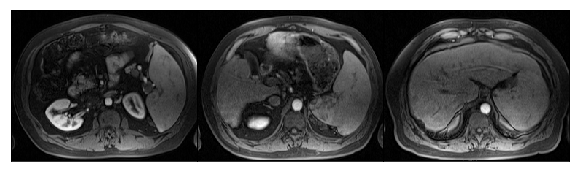

In [35]:
I = np.load(join(C.full_img_dir, accnum+".npy"))
print(I.shape)
vis.draw_slices(I[...,0])

(256, 208, 80)


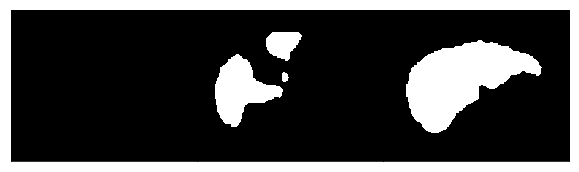

In [36]:
I = np.load(join(C.full_img_dir, accnum+"_liverseg.npy"))
print(I.shape)
vis.draw_slices(I)

(256, 208, 80)


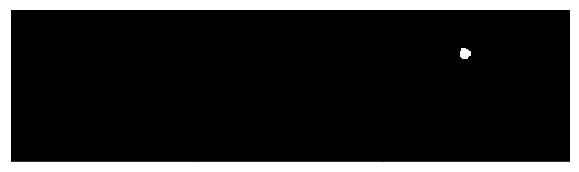

In [38]:
I = np.load(join(C.full_img_dir, accnum+"_tumorseg.npy"))
print(I.shape)
vis.draw_slices(I)

In [12]:
Z = ["12569826_2", "E103354676_1", "E100459207_2", "13010227_0", "13003974_0", "12874178_0"]

In [ ]:
vm.save_imgs_with_bbox(Z)

In [29]:
drm.dcm2npy_batch(acc_nums=["13216353"], overwrite=True)

In [ ]:
vm.reset_accnum("13216353")

In [19]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [20]:
voi_df_art[voi_df_art["accnum"].str.startswith("790003")]

,accnum,x1,x2,y1,y2,z1,z2,cls,real_dx,real_dy,real_dz,run_num
790003_1,790003,134,158,68,92,37,52,hbv,51.0,51.0,45.0,1
790003_0,790003,134,158,68,92,37,52,hcv,51.0,51.0,45.0,1
790003_2,790003,134,158,68,92,37,52,nonviral,51.0,51.0,45.0,1


In [ ]:
importlib.reload(drm)
cls = "hbv"
acc_num = '790003'
img = np.load(C.full_img_dir+"\\"+cls + "\\"+acc_num + ".npy")
vis.draw_flipped_slices(img, voi_df_art[(voi_df_art["acc_num"] == acc_num) & (voi_df_art["cls"] == cls)].iloc[0])
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

In [61]:
importlib.reload(vm)
[vm.reset_accnum(x[:-2]) for x in ['13010227_0', 'E105993177_0',
 'E100852770_0', 'E103835733_0', '12888679_0', 'E100458776_0', 'E100894274_0']]

.......

[None, None, None, None, None, None, None]

-0.9749059606481485 0.9052014807754605 -0.0664152584179922


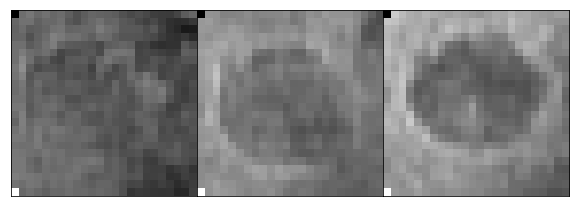

In [38]:
importlib.reload(vm)
img = vm.plot_check(2, "13216353", normalize=[-1,1])
print(np.amin(img), np.amax(img), np.mean(img))

In [ ]:
for cls in C.classes_to_include:
    print(cls)
    print('\n'.join([x[:-4] for x in os.listdir("E:\\lesion_imgs_small\\"+cls)]))
    #vm.save_vois_as_imgs(cls=cls, save_dir="E:\\lesion_imgs_small\\"+cls, fn_suffix="")

In [294]:
lids = ['E106097391_0.npy', 'E104978772_1.npy', '12900535_0.npy', 'E100150242_0.npy', 'E105490014_0.npy', 'E103147618_0.npy', 'E103510187_0.npy', 'E104657225_0.npy', 'E100551966_0.npy', 'E101388602_0.npy', 'E100215900_8.npy', 'E100215900_7.npy', 'E104045692_0.npy', '13104521_0.npy', 'E100383453_0.npy', '12943286_0.npy', '12271995_0.npy', 'E102315724_0.npy', 'E104949189_0.npy', 'E100511083_1.npy', 'E101579471_0.npy', '13018986_1.npy', '13203550_8.npy', '13112385_0.npy', '12712463_0.npy', '12361082_0.npy', '13028374_0.npy', 'E103985934_1.npy', 'E100529980_0.npy', '12042703_3.npy', '12961059_0.npy', 'E105724706_2.npy', 'E100592424_2.npy', 'E103104254_0.npy', 'E104546069_0.npy', 'E101665217_1.npy', '12090000_0.npy', 'E100592424_1.npy', '12961059_1.npy', 'E105474285_0.npy', '12502068_1.npy', 'E100814791_0.npy', 'E102613189_0.npy', 'E105427046_0.npy', 'E102881031_1.npy', 'E102929168_0.npy', 'E102310482_0.npy', 'E102095465_0.npy', 'E101811299_0.npy', 'E104737273_0.npy', '12890053_0.npy', 'E100168661_1.npy', '12637865_0.npy', 'E100168661_2.npy', '12239783_0.npy', '12707781_0.npy', '12706568_1.npy', '12823036_0.npy', '12404081_0.npy', '12365693_1.npy']

In [301]:
lids = ['13018986_1', '13203550_8', 'E100168661_1', '12706568_1', 'E104189184_0', 'E100215900_7', '12900535_0', 'E100551966_0',
       'E102310482_0', 'E102095465_0', 'E105474285_0', 'E105724706_2']

In [32]:
misclass_img = ['E100610622_0', '12788616_0', '13092836_2', 'E100407633_0', 'E103312835_1', 'E103020139_1']

In [ ]:
vm.save_imgs_with_bbox(lesion_ids=misclass_img, save_dir="E:\\Z_test", separate_by_cls=False)

In [8]:
importlib.reload(vm)
save_dir = "D:\\Paula-project\\screenshots"
#save_dir = "E:\\lesion_imgs_small"
vm.save_vois_as_imgs(save_dir=save_dir, separate_by_cls=True, normalize=[-1,1])

# Generate reader study samples

In [24]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [120]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

banned_accnums = [z[:z.find('_')] for z in Z_reader]

voi_reader = voi_df_art[voi_df_art["id"].isin(Z_reader)]#voi_df_art[voi_df_art.index.isin(Z_reader)]

In [260]:
f_map = {}
b_map = {}
cls_map = {}

for cls in C.classes_to_include:
    for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
        img_id = str(sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])
        acc_num = row["Filename"][:-4] #row["acc_num"]
        f_map[row["id"]] = img_id
        b_map[img_id] = row["id"]#acc_num
        cls_map[row["id"]] = row["cls"]#acc_num
        #if cls == "fnh":#img_id == "4613":
        print("Z:\\DICOMs\\" + cls + "\\" + acc_num, 
              row["x1"], row["x2"], row["y1"], row["z1"], "---", img_id)
        try:
            print(b_map[img_id])
        except:
            pass

#f_map['E100199185'] = '46130'
#b_map['4613'] = "12678910_1"
#b_map['46130'] = "E100199185_0"

In [262]:
with open('Z:\\answer_key.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for k in Z_reader:
        writer.writerow([k, f_map[k], cls_map[k]])

In [ ]:
hitlist = []
replacements = []

for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047'] + ['4354', '3049', '5438'] + ['46130']:#['4158', '5720', '46130', '7444']:
    print(cls_map[b_map[secret_id]])
    hitlist.append(b_map[secret_id])
    replacements.append(cls_map[b_map[secret_id]])

In [165]:
for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047']:
    base_dir = r"Z:\Inter-reader study\DICOMs"
    shutil.move(os.path.join(base_dir, secret_id), os.path.join(base_dir, "Unused", secret_id))

In [33]:
multi_accnums = [accnum for accnum, count in zip(*np.unique(list(b_map.values()), return_counts=True)) if count>1]
print(multi_accnums)

In [276]:
for _, row in voi_reader.iterrows():
    cls = row["cls"]
    acc_num = str(row["Filename"])[:-4]
    for protocol in ["T1_AP", "T1_VP", "T1_EQ"]:
        target_dir = os.path.join("Z:\\Inter-reader study\\DICOMs\\extras", row['id'], protocol)
        shutil.copytree(os.path.join("Z:\\DICOMs", cls, acc_num, protocol), target_dir)

In [ ]:
for acc_num in f_map:
    try:
        os.rename(os.path.join("Z:\\Inter-reader study\\DICOMs", acc_num),
                  os.path.join("Z:\\Inter-reader study\\DICOMs", f_map[acc_num]))
    except Exception as e:
        print(acc_num, e)

# Read Run Stats

In [64]:
a = ['E106158268_0','E102424706_0','12570256_0','E100574689_0','E106120112_0','E100899012_0','E103678771_0','E105095742_0','E100899012_1','13278054_0','E100834987_0','13094833_0','E102088195_1','E101554830_0','12801670_0','E100304876_1','13013150_0','12807018_0','E101449797_0','12249331_0','E101686218_0','12993437_1','E101158768_0','E101356604_0','E105124678_0','12993437_0','E100793044_0','E104587275_0','E104099161_0','E105152299_0','E102031795_1','E100623842_0','E102388865_0','E103301795_0','E100814791_0','13160747_0','E101880575_0','12248774_1','12914169_0','E101442376_0','13197011_0']

In [66]:
vm.save_vois_as_imgs(save_dir=r"Z:\Paula\Screenshots")

In [25]:
import cnn_builder as cbuild
A = cbuild._collect_unaug_data()

Using TensorFlow backend.


In [ ]:
df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
mis_test += df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

In [ ]:
for z in sorted_x:
    print(z[0],'\t',z[1])

In [18]:
vm.save_vois_as_imgs(lesion_ids=[k for k in x if x[k]>2 and k!=""], save_dir="Z:\\Paula\\Misclassifications", separate_by_cls=True, normalize=[-1,1])

df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == 10) & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] < 1515879326)]

In [13]:
df = pd.read_csv(C.run_stats_path)

In [15]:
df = df.iloc[[-4,-3,-1]]

In [33]:
train_acc = [1-x.count("_")/140 for x in df['misclassified_train'].values] #434

In [16]:
cms = df['confusion_matrix'].values
cms = ''.join(cms)

supercm = hf.str_to_lists(cms, dtype=int)
supercm = [supercm[rownum:rownum+C.nb_classes] for rownum in range(0,len(supercm),C.nb_classes)]
supercm = np.array(supercm)

cm_sum = np.empty((C.nb_classes,C.nb_classes))

for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        print(cm_sum[j,i],end='\t')
    print()

29.0	0.0	0.0	0.0	0.0	1.0	
0.0	26.0	1.0	0.0	0.0	0.0	
0.0	3.0	29.0	0.0	2.0	0.0	
0.0	0.0	0.0	28.0	0.0	0.0	
0.0	1.0	0.0	0.0	28.0	4.0	
1.0	0.0	0.0	2.0	0.0	25.0	


In [7]:
np.sum(cm_sum[0,:])

750.0

In [12]:
avg_tpr = cm_sum[0,0]/np.sum(cm_sum[0,:])
avg_fpr = np.sum(cm_sum[1:,0])/np.sum(cm_sum[1:,:])

In [7]:
fpr = [np.sum(cm[1:,0])/np.sum(cm[1:,:]) for cm in supercm]
tpr = [cm[0,0]/np.sum(cm[0,:]) for cm in supercm]

In [5]:
test_num = 10
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+test_num] for rownum in range(0,len(predictions),test_num)]
predictions = np.array(predictions)

hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(len(df)):
    for lesion_num in range(test_num):
        if truths[run_num, lesion_num] == C.classes_to_include.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            if predictions[run_num, lesion_num, 0] in thresh_dict:
                thresh_dict[predictions[run_num, lesion_num, 0]+1e-6] = 'hcc'
            else:
                thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            if predictions[run_num, lesion_num, 0] in thresh_dict:
                thresh_dict[predictions[run_num, lesion_num, 0]+1e-6] = 'non-hcc'
            else:
                thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

In [190]:
true = len(thresh_dict)//2
false = len(thresh_dict)//2
TPR = [true/true]
FPR = [false/false]
a=0
hcc_correct = len(thresh_dict)//2
hcc_wrong = len(thresh_dict)//2
for key in sorted(thresh_dict):
    if key > minT[1]:
        break
    if key > minT[0]:
        a+=1
        if thresh_dict[key] != 'hcc':
            hcc_wrong -= 1
    elif thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/true)
    FPR.append(hcc_wrong/false)

In [189]:
minT=[.68,.99]

In [191]:
R = (1-FPR[-1], TPR[-1])
R

(0.9, 0.9)

In [186]:
a/len(thresh_dict)

0.6206666666666667

In [180]:
hcc_fpos_cost = 12000
hcc_miss_cost = 5000
biopsy_cost = 1400

In [81]:
nonhcc_thresh = np.array(nonhcc_thresh)
hcc_thresh = np.array(hcc_thresh)
all_thresh = np.array(list(thresh_dict.keys()))

In [178]:
(hcc_thresh < minT[0]).sum()

11

In [183]:
(nonhcc_thresh > minT[1]).sum()

0

In [200]:
true_spec = (nonhcc_thresh < minT[0]).sum() / (750 - ((nonhcc_thresh < minT[1]) & (nonhcc_thresh > minT[0])).sum())
true_sens = (hcc_thresh > minT[1]).sum() / (750 - ((hcc_thresh < minT[1]) & (hcc_thresh > minT[0])).sum())
true_spec, true_sens

(1.0, 0.0)

In [155]:
fun = lambda T: hcc_fpos_cost * (nonhcc_thresh > T[1]).sum() + hcc_miss_cost * (hcc_thresh < T[0]).sum() + \
        biopsy_cost * ((all_thresh < T[1]) & (all_thresh > T[0])).sum()

In [165]:
import math

In [198]:
minC=1e10
for T1 in np.linspace(0,1,100,False):
    for T2 in np.linspace(T1,1,(1-T1)*100+1):
        C = fun([T1,T2])
        if minC > C:
            minC = C
            minT = [T1,T2]

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
minC

1028000

In [199]:
minT

[0.03, 1.0]

In [93]:
scipy.optimize.basinhopping(fun, [0,1], T=.1)

                        fun: 1234000
 lowest_optimization_result:       fun: 1234000
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.50207778, 0.44547252])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 428
                        nit: 100
                       njev: 107
                          x: array([0.50207778, 0.44547252])

In [62]:
rates05, (avg_fpr, avg_tpr), rates95

((0.25066666666666665, 0.9786666666666667),
 (0.18, 0.9266666666666666),
 (0.12533333333333332, 0.7893333333333333))

In [13]:
avg_fpr, avg_tpr

(0.18, 0.9266666666666666)

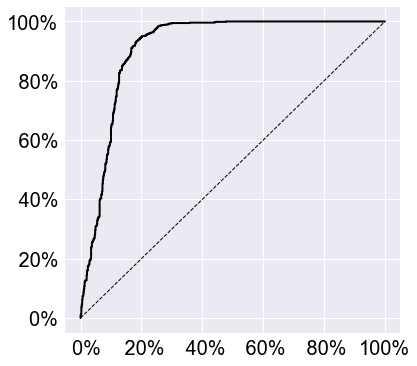

In [6]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.plot(FPR, TPR, 'k', label='Model', linewidth=2)
#ax.plot(.04, 1, 'ko', label='ModelReader', markersize=12)
#ax.plot(0, .7, 'k^', label='RAD2', markersize=12)
#ax.plot(0, .6, 'k ^', label='RAD1', markersize=12)
#ax.plot(avg_fpr, avg_tpr, 'ko', label='ModelAvg', markersize=10)
#ax.plot(rates10[0], rates10[1], 'ko', label='10%', markersize=10)
#ax.plot(rates95[0], rates95[1], 'ko', label='90%', markersize=10)
#ax.plot(rates05[0], rates05[1], 'ko', label='5%', markersize=10)
#ax.plot(rates98[0], rates98[1], 'ko', label='95%', markersize=10)
#ax.plot(fpr, tpr, 'o', ms=5)
ax.plot([0,1], [0,1], 'k--', lw=1)
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')

#ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
#ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

In [56]:
sp.plot(FPR, TPR, 'k', label='Model', linewidth=3)
sp.plot(.1, .9, 'g^', label='Model', markersize=10)
sp.plot(.43, 1., 'r^', label='R2', markersize=10)
sp.plot(.67, 1., 'b^', label='R1', markersize=10)

In [63]:
AUC = sum([(FPR[i]-FPR[i+1])*TPR[i] for i in range(len(FPR)-1)])
AUC

0.9124888888888876

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)

# Influence analysis

In [415]:
C = config.Config("lirads")

In [435]:
inf_df = pd.read_excel(r"D:\feature_analysis\influence21.xlsx")

In [419]:
DFs = hf.pickle_load(join(C.base_dir, "data", "DFs4.bin"))

In [420]:
for df in DFs:
    for ix, row in df.iterrows():
        if row[-7] > row[-5] + 50:# and row[-3] < 0:
            row[-6] = np.nan
            row[-4] = np.nan
            row[-2] = np.nan
        elif row[-5] > row[-3] + 25:# and row[-3] < 0:
            row[-4] = np.nan
            row[-2] = np.nan
        elif row[-3] > row[-1] + 25:# and row[-1] < 0:
            row[-2] = np.nan
        df.loc[ix] = row

In [436]:
inf_df = pd.concat([inf_df, DFs[0][["true_cls", "pred_cls"]]], axis=1, join='inner')

In [439]:
inf_df.dropna(inplace=True)

In [465]:
for lesion_id, row in inf_df.iterrows():
    R = row.values[:-2]
    den = R[R > 0].sum()
    if den != 0:
        R = R/den
    else:
        R = [np.nan]*len(R)
    inf_df.loc[lesion_id] = list(R) + list(row.values[-2:])

In [467]:
inf_df.dropna(inplace=True)

In [ ]:
inf_df[inf_df > 0][inf_df["pred_cls"] == "colorectal"].mean(0)

In [470]:
group_df = pd.DataFrame(columns=inf_df.columns[:-2])

In [484]:
for cls in np.unique(inf_df["pred_cls"]):
    group_df.loc[cls] = inf_df[inf_df > 0][inf_df["pred_cls"] == cls].mean(0)

In [486]:
group_df.transpose().to_excel(r"D:\feature_analysis\feature_influence.xlsx")